In [2]:
# Imports and setup

In [22]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.utils.class_weight import compute_class_weight
import cv2
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Set matplotlib style
plt.style.use('ggplot')
%matplotlib inline

# Define paths
DATA_DIR = './data/ISIC2018_Task3_Training_Input'
CSV_FILE = './data/ISIC2018_Task3_Training_GroundTruth.csv'
SEGMENTATION_DIR = './data/segmented_lesions'
MODEL_SAVE_PATH = './models/skin_lesion_model.keras'
IMG_SIZE = (128, 128)  
BATCH_SIZE = 16

# Create directories
os.makedirs('./models', exist_ok=True)
os.makedirs('./plots', exist_ok=True)
os.makedirs(SEGMENTATION_DIR, exist_ok=True)

In [26]:
# Load and analyze data

Classes: ['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']
Total images: 10015


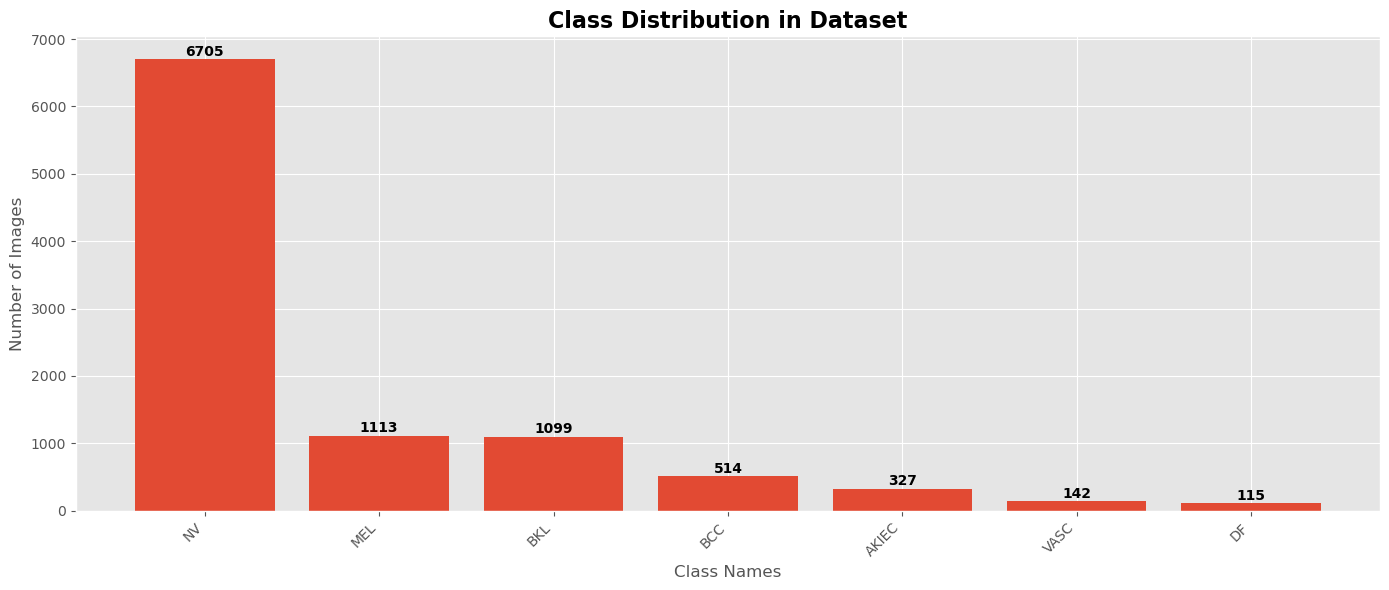

Class Distribution Table:
Class  Count Percentage
  MEL   1113     11.11%
   NV   6705     66.95%
  BCC    514      5.13%
AKIEC    327      3.27%
  BKL   1099     10.97%
   DF    115      1.15%
 VASC    142      1.42%


In [28]:
def load_isic_data(data_dir, csv_file):
    """Load ISIC dataset and return image paths and labels"""
    df = pd.read_csv(csv_file)
    image_paths = [os.path.join(data_dir, f"{img_id}.jpg") for img_id in df['image']]
    labels_one_hot = df.iloc[:, 1:].values
    labels = labels_one_hot.argmax(axis=1)
    class_names = df.columns[1:].tolist()
    label_names = [class_names[i] for i in labels]
    return image_paths, labels, label_names, class_names

# Load the data
image_paths, labels, label_names, class_names = load_isic_data(DATA_DIR, CSV_FILE)
print(f'Classes: {class_names}')
print(f'Total images: {len(image_paths)}')

# Enhanced class distribution plot
plt.figure(figsize=(14, 6))
counts = pd.Series(label_names).value_counts()
bars = plt.bar(range(len(counts)), counts.values)
plt.xticks(range(len(counts)), counts.index, rotation=45, ha='right')
plt.title('Class Distribution in Dataset', fontsize=16, fontweight='bold')
plt.xlabel('Class Names', fontsize=12)
plt.ylabel('Number of Images', fontsize=12)

# Add value labels on bars
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 5,
             f'{int(height)}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('./plots/class_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

# Class distribution table
class_distribution = pd.DataFrame({
    'Class': class_names,
    'Count': [np.sum(labels == i) for i in range(len(class_names))],
    'Percentage': [f"{(np.sum(labels == i) / len(labels)) * 100:.2f}%" 
                   for i in range(len(class_names))]
})
print("Class Distribution Table:")
print(class_distribution.to_string(index=False))

In [30]:
# Enhanced sample visualization

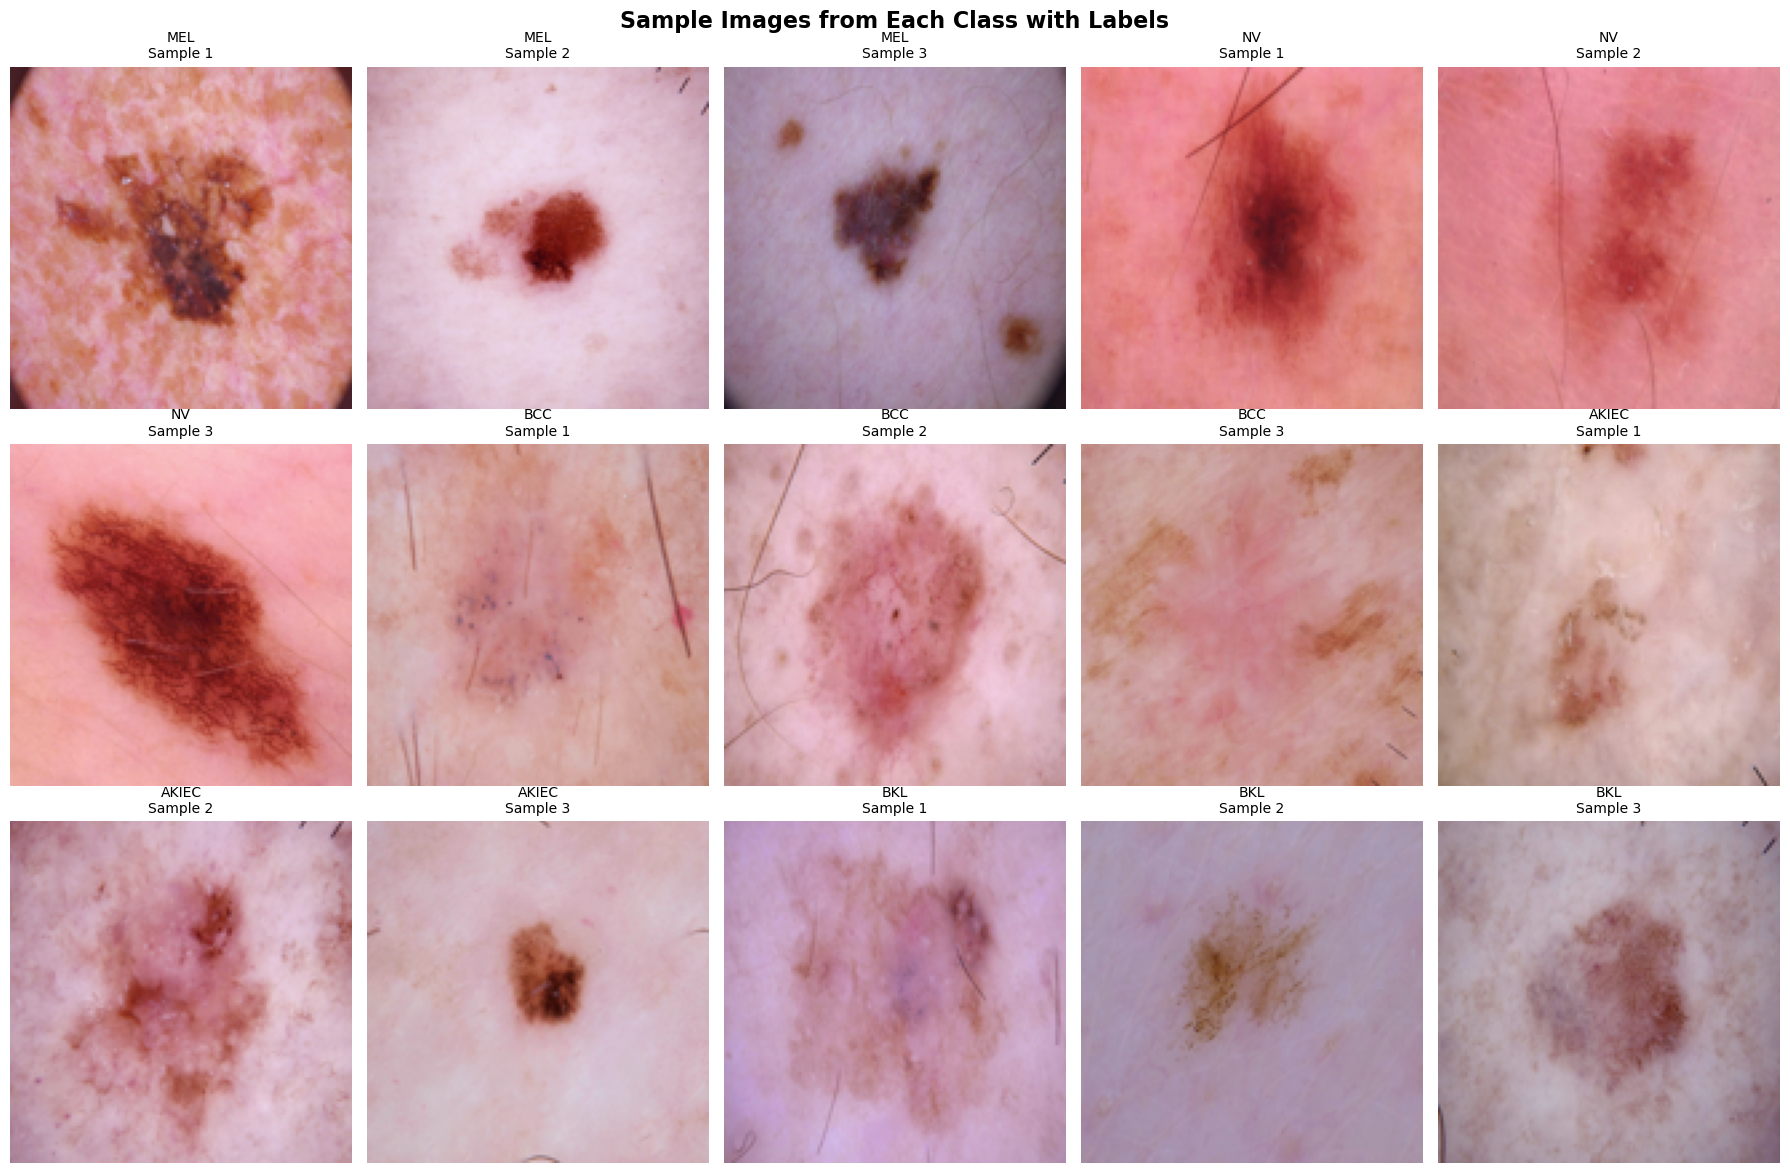

In [32]:
fig, axes = plt.subplots(3, 5, figsize=(18, 12))
fig.suptitle('Sample Images from Each Class with Labels', fontsize=16, fontweight='bold')

# Get samples from each class
class_samples = {}
for i, class_name in enumerate(class_names):
    class_indices = np.where(labels == i)[0]
    if len(class_indices) > 0:
        class_samples[class_name] = class_indices[:3]  # 3 samples per class

# Plot samples
plot_idx = 0
for class_name, indices in class_samples.items():
    for j, idx in enumerate(indices):
        if plot_idx < 15:  # 3 rows x 5 columns
            row, col = plot_idx // 5, plot_idx % 5
            img = Image.open(image_paths[idx]).resize(IMG_SIZE)
            axes[row, col].imshow(img)
            axes[row, col].set_title(f'{class_name}\nSample {j+1}', fontsize=10)
            axes[row, col].axis('off')
            plot_idx += 1

# Hide any empty subplots
for i in range(plot_idx, 15):
    row, col = i // 5, i % 5
    axes[row, col].axis('off')

plt.tight_layout()
plt.savefig('./plots/sample_images.png', dpi=300, bbox_inches='tight')
plt.show()

In [34]:
# U-Net Segmentation Model with VGG16 Encoder

In [36]:
def create_unet_segmentation_model(input_shape=(128, 128, 3)):
    """Create U-Net model with VGG16 encoder for segmentation"""
    # VGG16 encoder
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    
    # Freeze encoder layers
    for layer in base_model.layers:
        layer.trainable = False
    
    # Encoder layers
    s1 = base_model.get_layer('block1_conv2').output
    s2 = base_model.get_layer('block2_conv2').output
    s3 = base_model.get_layer('block3_conv3').output
    s4 = base_model.get_layer('block4_conv3').output
    
    # Bridge
    b1 = base_model.get_layer('block5_conv3').output
    
    # Decoder with skip connections
    d1 = layers.Conv2DTranspose(512, (3, 3), strides=(2, 2), padding='same')(b1)
    d1 = layers.concatenate([d1, s4])
    d1 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(d1)
    d1 = layers.Conv2D(512, (3, 3), activation='relu', padding='same')(d1)
    
    d2 = layers.Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same')(d1)
    d2 = layers.concatenate([d2, s3])
    d2 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(d2)
    d2 = layers.Conv2D(256, (3, 3), activation='relu', padding='same')(d2)
    
    d3 = layers.Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same')(d2)
    d3 = layers.concatenate([d3, s2])
    d3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(d3)
    d3 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(d3)
    
    d4 = layers.Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same')(d3)
    d4 = layers.concatenate([d4, s1])
    d4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(d4)
    d4 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(d4)
    
    # Output layer
    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(d4)
    
    model = models.Model(inputs=base_model.input, outputs=outputs)
    return model

# Create segmentation model
segmentation_model = create_unet_segmentation_model()
segmentation_model.summary()

# Visualize model architecture
tf.keras.utils.plot_model(segmentation_model, to_file='./plots/segmentation_model.png', 
                          show_shapes=True, show_layer_names=True)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)    │ (None, 128, 128, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1_conv1 (Conv2D)         │ (None, 128, 128, 64)      │           1,792 │ input_layer_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1_conv2 (Conv2D)         │ (None, 128, 128, 64)      │          36,928 │ block1_conv1[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block1_pool (MaxPooling2D)    │ (None, 64, 64, 64)        │               0 │ block1_conv2[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2_conv1 (Conv2D)         │ (None, 64, 64, 128)       │          73,856 │ block1_pool[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2_conv2 (Conv2D)         │ (None, 64, 64, 128)       │         147,584 │ block2_conv1[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block2_pool (MaxPooling2D)    │ (None, 32, 32, 128)       │               0 │ block2_conv2[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block3_conv1 (Conv2D)         │ (None, 32, 32, 256)       │         295,168 │ block2_pool[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block3_conv2 (Conv2D)         │ (None, 32, 32, 256)       │         590,080 │ block3_conv1[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block3_conv3 (Conv2D)         │ (None, 32, 32, 256)       │         590,080 │ block3_conv2[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block3_pool (MaxPooling2D)    │ (None, 16, 16, 256)       │               0 │ block3_conv3[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block4_conv1 (Conv2D)         │ (None, 16, 16, 512)       │       1,180,160 │ block3_pool[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block4_conv2 (Conv2D)         │ (None, 16, 16, 512)       │       2,359,808 │ block4_conv1[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block4_conv3 (Conv2D)         │ (None, 16, 16, 512)       │       2,359,808 │ block4_conv2[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block4_pool (MaxPooling2D)    │ (None, 8, 8, 512)         │               0 │ block4_conv3[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block5_conv1 (Conv2D)         │ (None, 8, 8, 512)         │       2,359,808 │ block4_pool[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ block5_conv2 (Conv2D)         │ (None, 8, 8, 512)         │       2,359,808 │ block5_conv1[0][0]         │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 28,025,537 (106.91 MB)

 Trainable params: 13,310,849 (50.78 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [38]:
# Enhanced mask creation with visualization

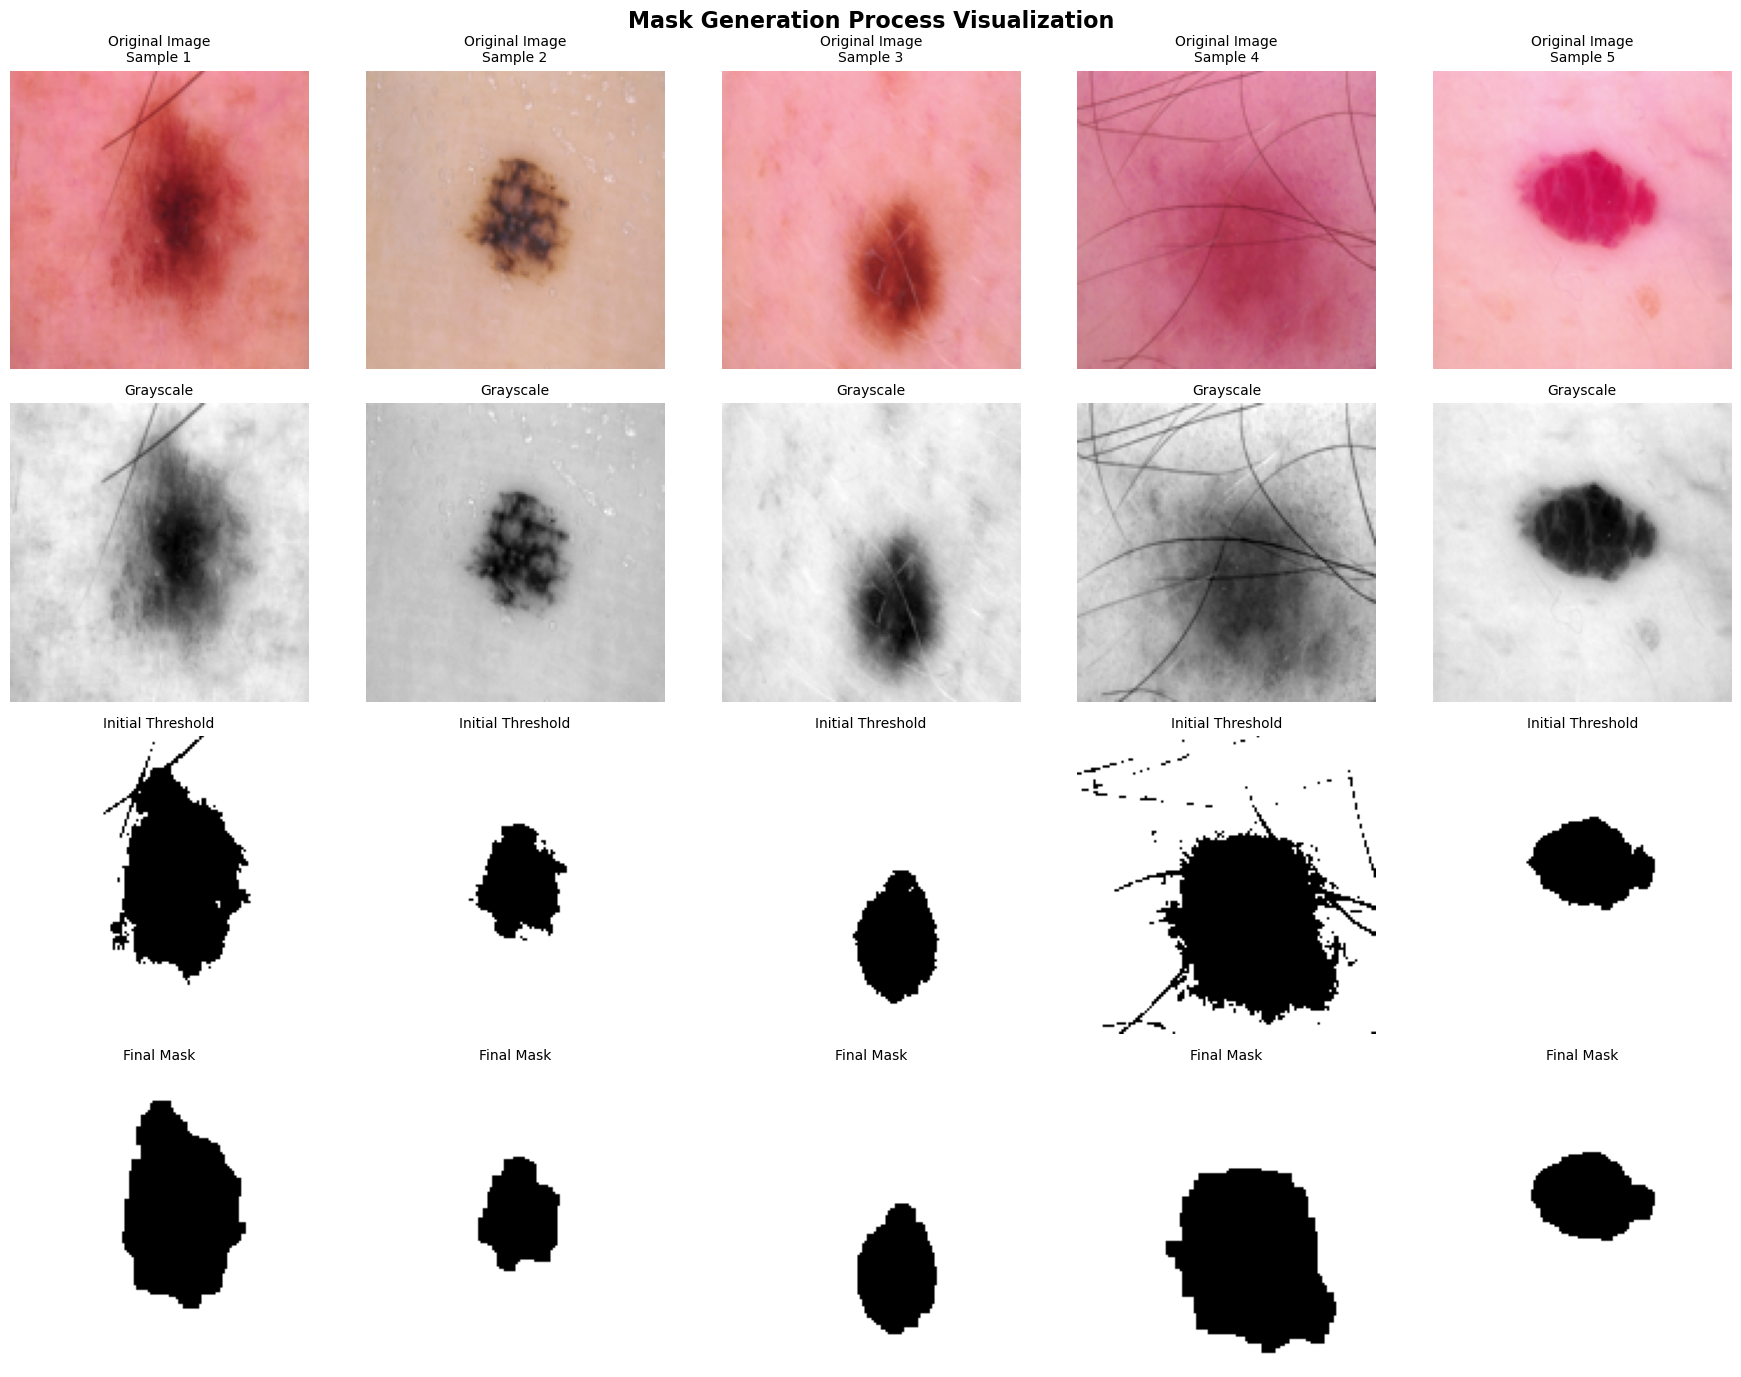

In [40]:
def create_simple_mask(image_path):
    """Create a simple circular mask approximation for training"""
    img = Image.open(image_path).resize(IMG_SIZE)
    img_array = np.array(img)  # Keep as uint8 (0-255)
    
    # Simple threshold-based mask
    gray = cv2.cvtColor(img_array, cv2.COLOR_RGB2GRAY)
    _, mask = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)  # Use 127 instead of 0.5
    
    # Convert to float and normalize
    mask = mask.astype(np.float32) / 255.0
    
    # Apply morphological operations to clean up
    kernel = np.ones((5, 5), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    
    return mask

# Enhanced mask visualization
fig, axes = plt.subplots(4, 5, figsize=(18, 14))
fig.suptitle('Mask Generation Process Visualization', fontsize=16, fontweight='bold')

for i in range(5):
    img_path = image_paths[i * 100]  # Sample different images
    
    # Original image
    img = Image.open(img_path).resize(IMG_SIZE)
    axes[0, i].imshow(img)
    axes[0, i].set_title(f'Original Image\nSample {i+1}', fontsize=10)
    axes[0, i].axis('off')
    
    # Grayscale
    gray = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2GRAY)
    axes[1, i].imshow(gray, cmap='gray')
    axes[1, i].set_title(f'Grayscale', fontsize=10)
    axes[1, i].axis('off')
    
    # Initial threshold
    _, initial_mask = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)
    axes[2, i].imshow(initial_mask, cmap='gray')
    axes[2, i].set_title(f'Initial Threshold', fontsize=10)
    axes[2, i].axis('off')
    
    # Final mask after morphological operations
    final_mask = create_simple_mask(img_path)
    axes[3, i].imshow(final_mask, cmap='gray')
    axes[3, i].set_title(f'Final Mask', fontsize=10)
    axes[3, i].axis('off')

plt.tight_layout()
plt.savefig('./plots/mask_generation_process.png', dpi=300, bbox_inches='tight')
plt.show()

In [42]:
# Enhanced segmentation training with balanced sampling

In [44]:
def train_segmentation_model(image_paths, epochs=20):  
    """Train the segmentation model with generated masks"""
    # Prepare training data - use more diverse samples
    X_train = []
    y_train = []
    
    # Use STRATEGIC sampling 
    # Get balanced samples from each class
    class_indices = {}
    for i, label in enumerate(labels):
        if label not in class_indices:
            class_indices[label] = []
        class_indices[label].append(i)
    
    # Take balanced samples from each class
    samples_per_class = 50
    selected_indices = []
    
    for class_id in class_indices:
        class_samples = class_indices[class_id]
        if len(class_samples) > samples_per_class:
            selected = np.random.choice(class_samples, samples_per_class, replace=False)
        else:
            selected = class_samples  # Use all if class is small
        selected_indices.extend(selected)
    
    print(f"Training on {len(selected_indices)} BALANCED samples")
    print(f"Samples per class: {samples_per_class}")
    
    for idx in selected_indices:
        img_path = image_paths[idx]
        img = Image.open(img_path).resize(IMG_SIZE)
        img_array = np.array(img) / 255.0
        mask = create_simple_mask(img_path)
        
        X_train.append(img_array)
        y_train.append(mask)
    
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    y_train = np.expand_dims(y_train, axis=-1)
    
    print(f"Training data shape: {X_train.shape}")
    
    # Compile model with better optimizer settings
    segmentation_model.compile(
        optimizer=Adam(learning_rate=1e-4, beta_1=0.9, beta_2=0.999),
        loss='binary_crossentropy',
        metrics=['accuracy', 'mse']  # Added MSE for better monitoring
    )
    
    # Add proper callbacks for better training
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6),
        ModelCheckpoint('./models/segmentation_best.keras', monitor='val_accuracy', save_best_only=True)
    ]
    
    # Train with validation
    print(f"Training segmentation model for {epochs} epochs...")
    history = segmentation_model.fit(
        X_train, y_train,
        batch_size=4,
        epochs=epochs,
        validation_split=0.2,
        callbacks=callbacks,
        verbose=1,
        shuffle=True
    )
    
    return history

# Train segmentation model
seg_history = train_segmentation_model(image_paths, epochs=20)

Training on 350 BALANCED samples
Samples per class: 50
Training data shape: (350, 128, 128, 3)
Training segmentation model for 20 epochs...
Epoch 1/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 165s 2s/step - accuracy: 0.7763 - loss: 0.4987 - mse: 0.1608 - val_accuracy: 0.9501 - val_loss: 0.1647 - val_mse: 0.0415 - learning_rate: 1.0000e-04
Epoch 2/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 148s 2s/step - accuracy: 0.9238 - loss: 0.1920 - mse: 0.0562 - val_accuracy: 0.9684 - val_loss: 0.1105 - val_mse: 0.0268 - learning_rate: 1.0000e-04
Epoch 3/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 156s 2s/step - accuracy: 0.9441 - loss: 0.1451 - mse: 0.0417 - val_accuracy: 0.9763 - val_loss: 0.0765 - val_mse: 0.0189 - learning_rate: 1.0000e-04
Epoch 4/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 161s 2s/step - accuracy: 0.9497 - loss: 0.1309 - mse: 0.0377 - val_accuracy: 0.9793 - val_loss: 0.0618 - val_mse: 0.0158 - learning_rate: 1.0000e-04
Epoch 5/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 145s 2s/step - accuracy: 0.9565 - loss: 0.1128 - mse: 0.0325 - val_accurac

In [45]:
# Training visualization

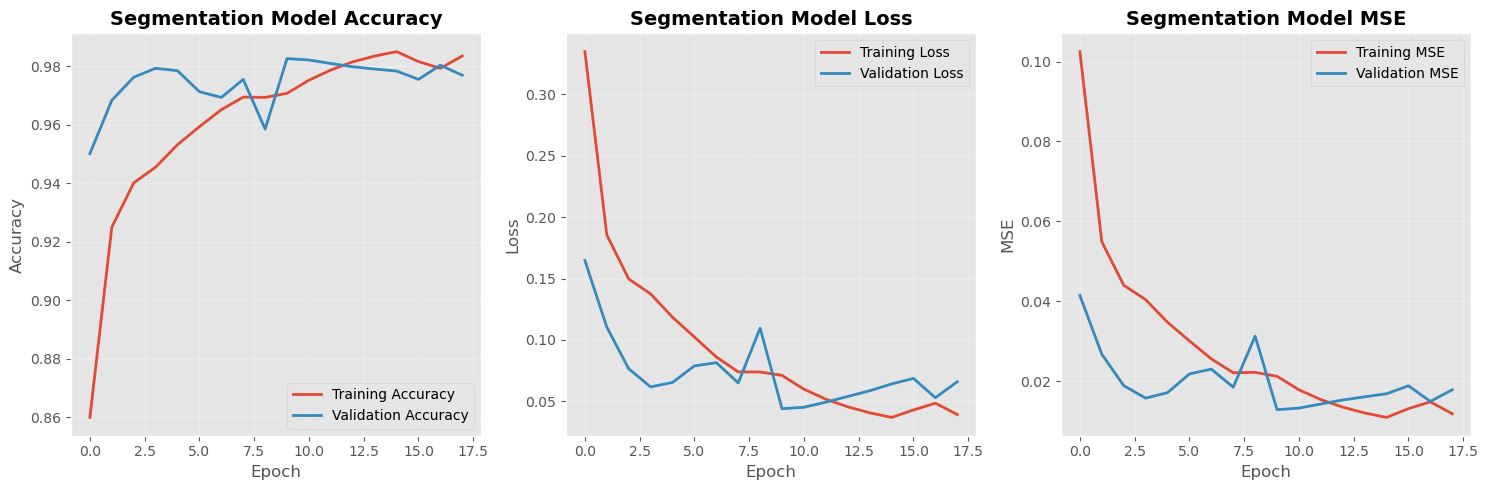

Final Segmentation Training Metrics:
                   Metric  Value
  Final Training Accuracy 0.9835
Final Validation Accuracy 0.9769
      Final Training Loss 0.0392
    Final Validation Loss 0.0659
       Final Training MSE 0.0119
     Final Validation MSE 0.0179


In [46]:
plt.figure(figsize=(15, 5))

# Accuracy plot
plt.subplot(1, 3, 1)
plt.plot(seg_history.history['accuracy'], label='Training Accuracy', linewidth=2)
plt.plot(seg_history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
plt.title('Segmentation Model Accuracy', fontsize=14, fontweight='bold')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)

# Loss plot
plt.subplot(1, 3, 2)
plt.plot(seg_history.history['loss'], label='Training Loss', linewidth=2)
plt.plot(seg_history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('Segmentation Model Loss', fontsize=14, fontweight='bold')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)

# MSE plot
plt.subplot(1, 3, 3)
plt.plot(seg_history.history['mse'], label='Training MSE', linewidth=2)
plt.plot(seg_history.history['val_mse'], label='Validation MSE', linewidth=2)
plt.title('Segmentation Model MSE', fontsize=14, fontweight='bold')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('MSE', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('./plots/segmentation_training_history.png', dpi=300, bbox_inches='tight')
plt.show()

# Final metrics table
final_metrics = pd.DataFrame({
    'Metric': ['Final Training Accuracy', 'Final Validation Accuracy', 
               'Final Training Loss', 'Final Validation Loss',
               'Final Training MSE', 'Final Validation MSE'],
    'Value': [f"{seg_history.history['accuracy'][-1]:.4f}", 
              f"{seg_history.history['val_accuracy'][-1]:.4f}",
              f"{seg_history.history['loss'][-1]:.4f}", 
              f"{seg_history.history['val_loss'][-1]:.4f}",
              f"{seg_history.history['mse'][-1]:.4f}", 
              f"{seg_history.history['val_mse'][-1]:.4f}"]
})
print("Final Segmentation Training Metrics:")
print(final_metrics.to_string(index=False))

In [50]:
# Segment all images and save segmented lesions

In [ ]:
def segment_and_save_images(image_paths, output_dir):
    """Segment all images and save the segmented lesions"""
    segmented_paths = []
    
    for i, img_path in enumerate(image_paths):
        # Load and preprocess image
        img = Image.open(img_path).resize(IMG_SIZE)
        img_array = np.array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)
        
        # Predict mask
        mask = segmentation_model.predict(img_array, verbose=0)[0]
        mask = (mask > 0.5).astype(np.uint8)
        
        # Apply mask to original image
        segmented = img_array[0] * np.repeat(mask, 3, axis=-1)
        
        # Save segmented image
        img_name = os.path.basename(img_path)
        output_path = os.path.join(output_dir, img_name)
        segmented_img = Image.fromarray((segmented * 255).astype(np.uint8))
        segmented_img.save(output_path)
        segmented_paths.append(output_path)
        
        if i % 500 == 0:
            print(f"Processed {i}/{len(image_paths)} images")
    
    return segmented_paths

# Segment all images
print("Segmenting images...")
segmented_paths = segment_and_save_images(image_paths, SEGMENTATION_DIR)
print("Segmentation completed!")

Segmenting images...
Processed 0/10015 images
Processed 500/10015 images
Processed 1000/10015 images


In [ ]:
# Enhanced segmentation results visualization

In [ ]:
fig, axes = plt.subplots(4, 5, figsize=(18, 14))
fig.suptitle('Segmentation Results Visualization', fontsize=16, fontweight='bold')

for i in range(5):
    idx = i * 200  # Sample different images
    
    # Original image
    img = Image.open(image_paths[idx]).resize(IMG_SIZE)
    axes[0, i].imshow(img)
    axes[0, i].set_title(f'Original Image\nSample {i+1}', fontsize=10)
    axes[0, i].axis('off')
    
    # Predicted mask
    img_array = np.array(img) / 255.0
    mask = segmentation_model.predict(np.expand_dims(img_array, axis=0), verbose=0)[0]
    axes[1, i].imshow(mask.squeeze(), cmap='viridis')
    axes[1, i].set_title(f'Predicted Mask\nSample {i+1}', fontsize=10)
    axes[1, i].axis('off')
    
    # Mask overlay
    axes[2, i].imshow(img)
    axes[2, i].imshow(mask.squeeze(), cmap='jet', alpha=0.5)
    axes[2, i].set_title(f'Mask Overlay\nSample {i+1}', fontsize=10)
    axes[2, i].axis('off')
    
    # Segmented lesion
    segmented_img = Image.open(segmented_paths[idx])
    axes[3, i].imshow(segmented_img)
    axes[3, i].set_title(f'Segmented Lesion\nSample {i+1}', fontsize=10)
    axes[3, i].axis('off')

plt.tight_layout()
plt.savefig('./plots/segmentation_results.png', dpi=300, bbox_inches='tight')
plt.show()